In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [ ]:
def cholesky_to_covar(L_vect, laplacian= False):
    """
        Converts cholesky numpy array to covariance matrix and also gets the 
        determinant of covariance
    """
    L_mat = np.zeros((L_vect.shape[0], L_vect.shape[1], 2, 2))
    # Reshape L_0, L_1, L_2 into 2x2 Lower triangular matrix
    # [ L_0   0  ]
    # [ L_1   L_2]
    L_mat[:, :, 0, 0] = L_vect[:, :, 0]
    L_mat[:, :, 1, 0] = L_vect[:, :, 1]
    L_mat[:, :, 1, 1] = L_vect[:, :, 2]

    sigma = np.matmul(L_mat, np.transpose(L_mat, (0, 1, 3, 2)))
    sigma = scale_covariance(sigma, laplacian= laplacian)

    # Get determinant of the covariance
    det_cov = np.zeros((sigma.shape[0],sigma.shape[1]))
    for i in range(sigma.shape[0]):
        for j in range(sigma.shape[1]):
            det_cov[i,j] = np.linalg.det(sigma[i,j,:,:])

    return sigma, det_cov

def scale_covariance(covar, laplacian= False):
    
    return covar

def load_only(folderpath):
    cholesky = np.load(folderpath)
    return cholesky

def get_eigen(covar):
    vals, vecs = np.linalg.eigh(covar)
    order = vals.argsort()[::-1]
    vals  = vals[order]
    vecs  = vecs[:, order]
    theta = np.degrees(np.arctan(vecs[1, 0] / vecs[0, 0]))
    return vals, theta

def cov_to_array(cov):
    container = np.zeros((cov.shape[0], cov.shape[1], 2))
    print(container.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            vals, theta = get_eigen(cov[i][j])
            container[i][j] = vals
    
    return container


def load_to_covArray(model_folder_path):
    cholesky = load_only(model_folder_path)
    covar, det_covar = cholesky_to_covar(cholesky)
    cont = cov_to_array(covar)
    print(cont.shape)
    return cont

def arr_reshape(arr):
    new_arr = np.reshape(arr, (arr.shape[0], -1))
    return new_arr

def remove_nonmask_landmark(arr):
  #mask covered: 3rd landmark to 15th landmark, 31st to 36th, and 49th to 68th
  #mask not covered: 1st to 2nd, 16th to 30th, 37th to 48th 
  index = [i for i in range(1, 3)]
  b = [i for i in range(16, 31)]
  c = [i for i in range(37, 49)]
  index.extend(b)
  index.extend(c)
  arr = np.delete(arr, index, axis=1)
  return arr

In [ ]:
mask_data = load_to_covArray("mask_cholesky.npy")
normal_data = load_to_covArray("normal_cholesky.npy")

(622, 68, 2)
(622, 68, 2)
(600, 68, 2)
(600, 68, 2)


In [ ]:
mask_extracted = remove_nonmask_landmark(mask_data)
normal_extracted = remove_nonmask_landmark(normal_data)

print(mask_extracted.shape)
print(normal_extracted.shape)

(622, 39, 2)
(600, 39, 2)


In [ ]:
mask_data_flatten = arr_reshape(mask_extracted) #(622, 78)
y1 = np.zeros((mask_data_flatten.shape[0]), )
normal_data_flatten = arr_reshape(normal_extracted) #(600, 78)
y2 = np.ones((normal_data_flatten.shape[0]), )

x = np.concatenate((mask_data_flatten, normal_data_flatten), axis=0) #data
y = np.concatenate((y1, y2), axis=0) #class

print(x.shape)
print(y.shape)

X_train,X_test,y_train,y_test = train_test_split(x,y,shuffle=True,test_size = 0.3,random_state=101,stratify=y)

(1222, 78)
(1222,)


In [ ]:
# Split the dataset into training and test sets
X_train,X_test,y_train,y_test = train_test_split(x,y,shuffle=True,test_size = 0.3,random_state=101,stratify=y)

# Create an SVC model
model = SVC()

# Define the hyperparameter grid to search over
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.01, 0.1, 1],
}

# Create a GridSearchCV object to perform the grid search
grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from the grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluate the model on the test set
test_score = grid_search.score(X_test, y_test)
print(f"Test score: {test_score}")


Best parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Best score: 0.9824561403508772
Test score: 0.9836512261580381


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,shuffle=True,test_size = 0.3,random_state=101,stratify=y)

model = SVC(C=0.1, kernel='poly', gamma=0.01)

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.9836512261580381


In [ ]:
def svm_func_linear(X_train, y_train, X_test, y_test, x, y): #X and y are needed to calculate cross validation score

    model = SVC(C=0.1, kernel='poly', gamma=0.01)
    model.fit(X_train, y_train)
    #‘linear’, ‘poly’, ‘rbf’

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print("--------------------------------------------------------")
    print("Test Accuracy:",  accuracy_score(y_test, y_pred))
    print("--------------------------------------------------------")
    score = cross_val_score(model, x, y, cv=5, scoring='accuracy')
    print("Cross valdation avaerage score", score.mean())
    print("--------------------------------------------------------")
    f1 = f1_score(y_test, y_pred)
    print("f1 score", f1)

svm_func_linear(X_train, y_train, X_test, y_test, x, y)

--------------------------------------------------------
Test Accuracy: 0.9836512261580381
--------------------------------------------------------
Cross valdation avaerage score 0.9819872867179658
--------------------------------------------------------
f1 score 0.9834254143646408


In [ ]:
def RFC(X_train, y_train, X_test, y_test, x, y):
  model = RandomForestClassifier(max_depth=2, random_state=0)
  model.fit(X_train, y_train)
  y_pred = model.predict((X_test))
  print("--------------------------------------------------------")
  print("Test Accuracy LogisticRegression Model :",  accuracy_score(y_test, y_pred))
  print("--------------------------------------------------------")
  score = cross_val_score(model, x, y, cv=5, scoring='accuracy')
  print("Cross valdation avaerage score", score.mean())
  print("--------------------------------------------------------")
  f1 = f1_score(y_test, y_pred)
  print("f1 score", f1)
  
RFC(X_train, y_train, X_test, y_test, x, y)

--------------------------------------------------------
Test Accuracy LogisticRegression Model : 0.9809264305177112
--------------------------------------------------------
Cross valdation avaerage score 0.9844429575108732
--------------------------------------------------------
f1 score 0.9807162534435262


In [ ]:
def lr_func(X_train, y_train, X_test, y_test, X, y):
  model = LogisticRegression(max_iter=3000)
  # fitting the classifier
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  print("--------------------------------------------------------")
  print("Test Accuracy LogisticRegression Model :",  accuracy_score(y_test, y_pred))
  print("--------------------------------------------------------")
  score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
  print("Cross valdation avaerage score", score.mean())
  print("--------------------------------------------------------")
  f1 = f1_score(y_test, y_pred)
  print("f1 score", f1)

lr_func(X_train, y_train, X_test, y_test, x, y)

--------------------------------------------------------
Test Accuracy LogisticRegression Model : 0.9863760217983651
--------------------------------------------------------
Cross valdation avaerage score 0.981987286717966
--------------------------------------------------------
f1 score 0.9862258953168044


In [ ]:
def GNB(X_train, y_train, X_test, y_test, X, y):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("--------------------------------------------------------")
    print("Test Accuracy LogisticRegression Model :",  accuracy_score(y_test, y_pred))
    print("--------------------------------------------------------")
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Cross valdation avaerage score", score.mean())
    print("--------------------------------------------------------")
    f1 = f1_score(y_test, y_pred)
    print("f1 score", f1)

GNB(X_train, y_train, X_test, y_test, x, y)

--------------------------------------------------------
Test Accuracy LogisticRegression Model : 0.9400544959128065
--------------------------------------------------------
Cross valdation avaerage score 0.9492338574774173
--------------------------------------------------------
f1 score 0.9421052631578948


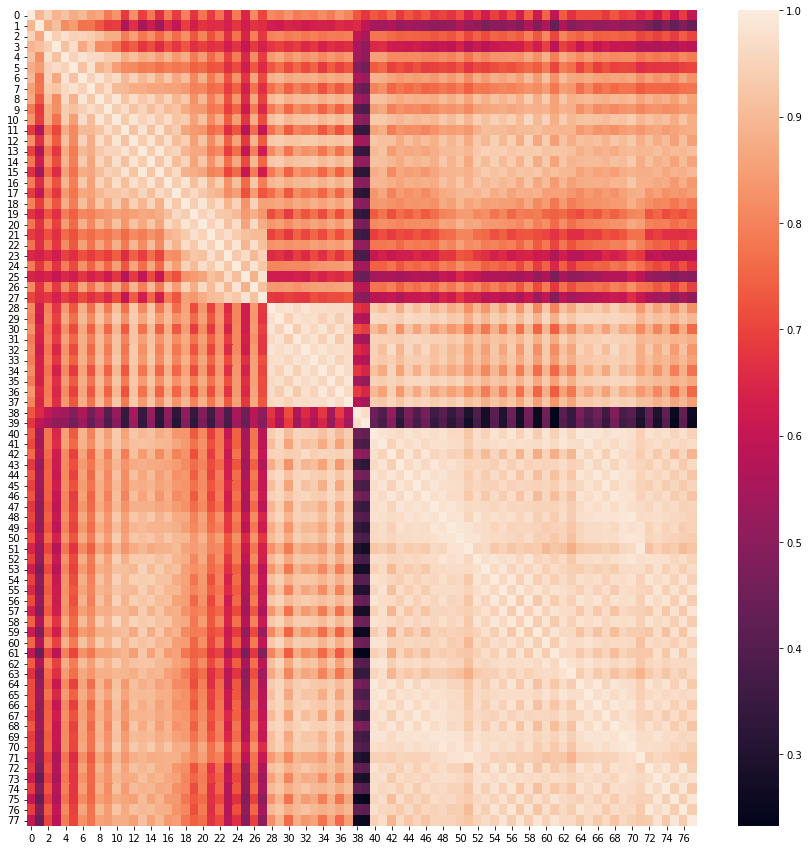

In [ ]:
import seaborn as sb
import pandas as pd

df = pd.DataFrame(x)

plt.figure(figsize=(15,15))
sb.heatmap(df.corr())

PCA visualization

(1222, 2)
(1222, 1)
(1222, 78)
0.0


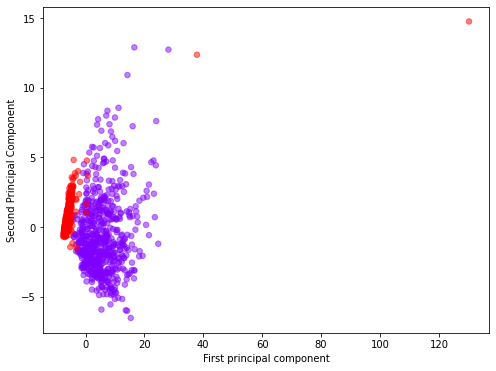

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd


df = pd.DataFrame(x)

scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

pca = PCA(n_components=2)
pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)

y_2d = np.reshape(y, (y.shape[0], 1))
print(x_pca.shape)
print(y_2d.shape)

arr = np.append(x_pca, y_2d, axis=1)
print(df.shape)

# x_pca = x_pca[:10,]


principalDf = pd.DataFrame(data = x_pca, columns = ['principal component 1', 'principal component 2'])
y_df = pd.DataFrame(data = y_2d, columns = ['class'])

finalDf = pd.concat([principalDf, y_df[['class']]], axis = 1)
# finalDf = finalDf[:10]

colors = (0,0,0)
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], s=30, c=finalDf['class'], cmap='rainbow', alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

print(y[10])

#the purple is mask data and class is 0
#the red dot is normal data and class is 1